In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from dataclasses import dataclass

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm.notebook import tqdm
from tensorflow.keras import regularizers


### Set seeds for reproducibility

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

### Check for GPU availability

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
else:
    print("Using CPU")


Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
lob_features = [
    "b0p", "b1p", "b2p", "b3p", "b4p", "b5p", "b6p", "b7p", "b8p", "b9p",
    "b0q", "b1q", "b2q", "b3q", "b4q", "b5q", "b6q", "b7q", "b8q", "b9q",
    "a0p", "a1p", "a2p", "a3p", "a4p", "a5p", "a6p", "a7p", "a8p", "a9p",
    "a0q", "a1q", "a2q", "a3q", "a4q", "a5q", "a6q", "a7q", "a8q", "a9q"
]

In [12]:
@dataclass
class Config:
    z_dim: int = 2*100  # Dimension of random noise
    batch_size: int = 32
    learning_rate_g: float = 0.0002
    learning_rate_d: float = 0.000002
    epochs: int = 50
    penalty_weight: int = 5
    sample_size: int = 5000
    faulty_rate_weight: int = 20
    # use_feature_matching: bool = False
    feature_matching_weight: int = 5 #20
    use_feature_matching: bool = False
    label_smoothing: float = 0.0
    use_historical_averaging: bool = False
    historical_averaging_weight: float = 0.0001

config = Config()

### Load and preprocess LOB data


In [13]:
file_path = "/content/drive/MyDrive/BTCUSDT-lob.parq"
df = pd.read_parquet(file_path, engine="pyarrow")

print(f"The legnth for the dataframe is {len(df)}")

The legnth for the dataframe is 189760


In [14]:
df.iloc[:, 25:40].head()

,a0p,a1p,a2p,a3p,a4p,a5p,a6p,a7p,a8p,a9p,a0q,a1q,a2q,a3q,a4q
0,95180.0,95180.1,95180.2,95180.6,95180.7,95180.8,95181.5,95181.6,95181.8,95181.9,8.937,0.190,0.036,0.002,0.095
1,95180.0,95180.1,95180.6,95180.7,95180.8,95181.5,95181.6,95181.8,95181.9,95182.0,8.953,0.154,0.002,0.095,0.002
2,95180.0,95180.1,95180.4,95180.6,95180.7,95180.8,95181.5,95181.6,95181.8,95181.9,8.953,0.154,0.042,0.002,0.095
3,95180.0,95180.1,95180.4,95180.6,95180.7,95180.8,95181.5,95181.6,95181.8,95181.9,8.953,0.154,0.042,0.002,0.095
4,95180.0,95180.1,95180.4,95180.6,95180.7,95180.8,95181.5,95181.6,95181.8,95181.9,8.957,0.154,0.042,0.002,0.095


In [15]:
df = df.dropna(subset=lob_features).sample(n=config.sample_size, random_state=42)

In [16]:
#scaler = MinMaxScaler()
#lob_data = scaler.fit_transform(df[lob_features].values).astype(np.float32) #(5000, 40)
# Remove min max scaler.
lob_data = df[lob_features].values.astype(np.float32) #(5000, 40)
lob_dataset = tf.data.Dataset.from_tensor_slices(lob_data).batch(config.batch_size)

#lob_dataset: TensorFlow Dataset object

In [17]:
for batch in lob_dataset.take(1):
    print(f"Dimension of lob_dataset: {batch.shape}")

Dimension of lob_dataset: (32, 40)


### Generator

In [18]:
# class Generator(models.Model):
#     def __init__(self, config):
#         super(Generator, self).__init__()
#         self.config = config
#         self.z_dim = config.z_dim

#         # For price vector (20 feature: 10 bid + 10 ask)
#         self.price_dense = layers.Dense(20)

#         # For quantity vector generation, ensure all are positive.
#         self.q_dense1 = layers.Dense(128, activation='relu')
#         # self.q_dense2 = layers.Dense(64, activation='relu')
#         # self.q_dense3 = layers.Dense(32, activation='relu')
#         self.q_output = layers.Dense(20)

#     def call(self, inputs, training=True):
#         # Split noise into two parts: one for price, one for quantity
#         z_price, z_volume = tf.split(inputs, num_or_size_splits=2, axis=1)

#         # Generate price vector
#         price_output = self.price_dense(z_price)
#         bid_prices = price_output[:, :10]
#         ask_prices = price_output[:, 10:20]

#         # Quantity vector generation
#         x_q = self.q_dense1(z_volume)
#         # x_q = self.q_dense2(x_q)
#         # x_q = self.q_dense3(x_q)
#         quantity_output = self.q_output(x_q)
#         bid_quantities = quantity_output[:, :10]
#         ask_quantities = quantity_output[:, 10:20]

#         # Combine: [b0p...b9p, b0q...b9q, a0p...a9p, a0q...a9q]
#         combined = tf.concat([bid_prices, bid_quantities, ask_prices, ask_quantities], axis=1)
#         return combined



class Generator(models.Model):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        self.z_dim = config.z_dim

        self.price_dense1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.price_dense2 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.price_output = layers.Dense(20)  # 10 bid + 10 ask

        self.q_dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.q_dense2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.q_dense3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.q_output = layers.Dense(20)  # 10 bid + 10 ask quantities

    def call(self, inputs, training=True):
        z_price, z_volume = tf.split(inputs, num_or_size_splits=2, axis=1)

        x_p = self.price_dense1(z_price)
        x_p = self.price_dense2(x_p)
        price_output = self.price_output(x_p)
        bid_prices = price_output[:, :10]
        ask_prices = price_output[:, 10:20]

        x_q = self.q_dense1(z_volume)
        x_q = self.q_dense2(x_q)
        x_q = self.q_dense3(x_q)
        quantity_output = self.q_output(x_q)
        bid_quantities = quantity_output[:, :10]
        ask_quantities = quantity_output[:, 10:20]

        # Combine to full LOB
        combined = tf.concat([bid_prices, bid_quantities, ask_prices, ask_quantities], axis=1)
        return combined



### Feature Matching

Feature matching involves the discriminator, the FeatureMatching class, and the training loop.

In the original paper, feature matching is primarily used to handle instability of training. The features is learnt by the discriminator using a dense layer called feature_layer, there is no specifications on what 'feature' it should be. The discriminator will return 1. the output obtained from feature_layer, 2. the 'feature'. In the FeatureMatching class, it calculates that 'feature' for a batch_size number of samples of both real and fake LOB, then calculates the sample mean for both real and fake LOB, finally return a loss defined as the difference in the sample means. In the training, this loss called fm_loss and is added to the gen_loss. Therefore, it acts like a penalty for having a different sample mean of that 'feature' compared to the sample mean of that 'feature' in the training data.

In our use case, to make the naming more explicit, I defined the 'feature' obtained using the feature_layer as 'magic_feature', since we will not know what this feature is going to represent (probably this is not related to those LOB rules). To enforce the LOB rules, I explictly calculated the LOB rules (the penalty that we used to have), and define it to be 'feature_vector'. My idea is that feature_layer will still be used for stability of training, but the FeatureMatching class should match the sample mean of the 'feature_vector' instead of 'magic_features'.

Originally, I made the discriminator to return 1. the output obtained from the output of 'magic_feature' after going through the feature_layer, 2. the 'feature_vector'.
        
        magic_features = self.magic_feature_dense(x)
        magic_features = self.magic_feature_leaky(magic_features)

        if self.use_minibatch_discrimination:
            discriminator_features = self.minibatch_layer(magic_features)
        else:
            discriminator_features = magic_features

        output = self.output_layer(discriminator_features)

        if return_features:
            return output, feature_vector
        else:
            return output
This made training unstable. Probably this has made generator confused, because the 'magic_feature' can be entirly unrelated to 'feature_vector'.

Thus, I did what I have now,
        combined_features = tf.concat([x, feature_vector], axis=1)

        magic_features = self.magic_feature_dense(combined_features)
        magic_features = self.magic_feature_leaky(magic_features)

        if self.use_minibatch_discrimination:
            discriminator_features = self.minibatch_layer(magic_features)
        else:
            discriminator_features = magic_features

        output = self.output_layer(discriminator_features)

        if return_features:
            return output, feature_vector
        else:
            return output
so that the 'magic_feature' is related to the 'feature_vector', and will make the generator less confused.

However, if we keep the basic structure of our generator (very few layers) the reduction in faulty rate is very minimal compared to using the penalty method, ususally start off at 75% then go down to 60% maximally, though the construction of 'feature_vector' itself should be identical to that of differentiable_faulty_penalty calculation. But when generator is slightly more complex (I added one more dense layer for price, faulty rate can go from 70% to 40%), possibly because generator can learn better?

Also, the general observation is that, during the later epochs seems like the faulty rate is increasing back, possibly because the adv_loss is dominating, suggest to weight the fm_loss dynamically. And when discriminator loss reaches 0 (too confident), then faulty rate and gen loss stops improving. Hence, label smoothing =0.9 is applied here.

One question, why is  elf.price_output = layers.Dense(40)  40 not 20?


In [19]:
## this is matching the batch-wise sample mean of difference in feature_vector for real and fake
# class FeatureMatching:
#     def __call__(self, real_features, fake_features):
#         real_mean = tf.reduce_mean(real_features, axis=0)
#         # tf.print("Real mean:", real_mean)
#         deviation = fake_features - real_mean
#         norm = tf.norm(deviation, axis=1)  # shape (batch,)
#         loss = tf.reduce_mean(norm)
#         return loss


# this is forcing the batch-wise sample mean of L2 norm of feature_vector
# class FeatureMatching:
#     def __call__(self, _, fake_features):  # ignore real_features for now since real features will be a vector of 0 anyways.
#         squared = tf.square(fake_features)
#         loss = tf.reduce_mean(squared)  # shape: scalar
#         return loss


# this is forcing the batch-wise sample mean of L1 norm of feature_vector
class FeatureMatching:
    def __call__(self, _, fake_features):
        loss = tf.reduce_mean(fake_features)  # L1 norm
        return loss


### Minibatch Discriminator

In [20]:
# Minibatch Discrimination code
class MinibatchDiscrimination(layers.Layer):
    """Minibatch discrimination layer to prevent mode collapse"""

    def __init__(self, num_kernels=100, dim_per_kernel=5, **kwargs):
        super(MinibatchDiscrimination, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.dim_per_kernel = dim_per_kernel

    def build(self, input_shape):
        #Defines a trainable weight (self.kernel) of shape (input_dim, num_kernels, dim_per_kernel)
        self.input_dim = input_shape[1] #Stores the number of features in the input tensor.
        kernel_shape = (self.input_dim, self.num_kernels, self.dim_per_kernel) #Shape of the kernel tensor
        initializer = tf.random_normal_initializer(stddev=0.02)
        self.kernel = self.add_weight(
            shape=kernel_shape,
            initializer=initializer,
            name='kernel',
            trainable=True
        )
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, inputs, **kwargs):
        #Computes a projection of inputs using self.kernel.
        #If inputs has shape (batch_size, input_dim),
        #And kernel has shape (input_dim, num_kernels, dim_per_kernel),
        #Then activation will have shape (batch_size, num_kernels, dim_per_kernel).
        #Got from dot product.
        activation = tf.tensordot(inputs, self.kernel, axes=[[1], [0]])

        #Expands dimensions to compare all batch samples.
        expanded_act = tf.expand_dims(activation, 3)
        transposed_act = tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)

        diff = expanded_act - transposed_act #
        abs_diff = tf.reduce_sum(tf.abs(diff), 2) #Computes the absolute differences between all pairs of samples.

        #Apply mask to avoid comparing a sample with itself.
        batch_size = tf.shape(inputs)[0]
        mask = 1.0 - tf.eye(batch_size)
        #Creates an identity matrix (tf.eye(batch_size)), which has 1s on the diagonal and subtracts it from 1.0. Ensures that the diagonal is 0.
        mask = tf.expand_dims(mask, 1)

        #Expands dimensions to match abs_diff.
        if mask.shape.ndims != abs_diff.shape.ndims:
            mask = tf.reshape(mask, [-1, mask.shape[1], batch_size])

        exp = tf.exp(-abs_diff) * mask
        minibatch_features = tf.reduce_sum(exp, 2)

        return tf.concat([inputs, minibatch_features], axis=1)

The final shape is (batch_size, input_dim + num_kernels).

Historical Averaging

In [21]:
class HistoricalAveraging:
    """
    Historical averaging to prevent oscillation in GAN training.
    This version avoids creating Variables inside tf.function.
    """

    def __init__(self, beta=0.99):
        self.beta = beta
        self.parameter_history = {}

    def initialize_if_needed(self, model):
        """Initialize parameter history outside of tf.function"""
        model_keys = [weight.name for weight in model.trainable_weights]

        for weight in model.trainable_weights:
            if weight.name not in self.parameter_history:
                self.parameter_history[weight.name] = weight.numpy()

    def __call__(self, model, weight=0.01):
        if not self.parameter_history:
            return tf.constant(0.0)

        total_loss = 0.0

        for curr_weight in model.trainable_weights:
            name = curr_weight.name

            if name not in self.parameter_history:
                continue

            curr_value = curr_weight
            hist_value = self.parameter_history[name]

            if curr_value.shape == hist_value.shape:
                hist_tensor = tf.convert_to_tensor(hist_value, dtype=curr_value.dtype)
                diff = curr_value - hist_tensor
                loss = tf.reduce_sum(tf.square(diff))
                total_loss += loss

        return weight * total_loss

    def update_history(self, model):
        """Update parameter history - call this AFTER each training step"""
        for weight in model.trainable_weights:
            name = weight.name
            if name in self.parameter_history:
                curr_value = weight.numpy()
                self.parameter_history[name] = self.beta * self.parameter_history[name] + (1 - self.beta) * curr_value

### Discriminator

No batch normalization for discriminator as BatchNorm normalizes across the batch, which may leak information between examples.

In [22]:
class Discriminator(models.Model):
    """Simple Discriminator for classifying real vs fake feature vectors with financial constraints"""
    def __init__(self, config, use_minibatch_discrimination=False):
        super(Discriminator, self).__init__()
        self.config = config
        self.use_minibatch_discrimination = use_minibatch_discrimination

        self.price_dense = layers.Dense(20, kernel_regularizer=regularizers.l2(1e-4))
        self.quantity_dense = layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.dense1 = layers.Dense(512, kernel_regularizer=regularizers.l2(1e-4))
        self.leaky1 = layers.LeakyReLU(alpha=0.2)

        self.magic_feature_dense = layers.Dense(64, kernel_regularizer=regularizers.l2(1e-4))
        self.magic_feature_leaky = layers.LeakyReLU(alpha=0.2)

        if use_minibatch_discrimination:
            self.minibatch_layer = MinibatchDiscrimination(num_kernels=100, dim_per_kernel=5)

        self.output_layer = layers.Dense(1) # a real/ fake classification

    def call(self, input, training=True, return_features=False):
        bid_price = input[:, :10]
        bid_quantity = input[:, 10:20]
        ask_price = input[:, 20:30]
        ask_quantity = input[:, 30:40]

        price_vector = tf.concat([bid_price, ask_price], axis=1)
        quantity_vector = tf.concat([bid_quantity, ask_quantity], axis=1)

        price_out = self.price_dense(price_vector)
        quantity_out = self.quantity_dense(quantity_vector)

        x = tf.concat([price_out, quantity_out], axis=1)
        x = self.dense1(x)
        x = self.leaky1(x)

        best_bid = bid_price[:, -1]
        best_ask = ask_price[:, 0]
        spread_violation = tf.nn.softplus(best_bid - best_ask)
        bid_diff = bid_price[:, :-1] - bid_price[:, 1:]
        bid_order_violation = tf.reduce_sum(tf.nn.softplus(-bid_diff), axis=1)
        ask_diff = ask_price[:, 1:] - ask_price[:, :-1]
        ask_order_violation = tf.reduce_sum(tf.nn.softplus(-ask_diff), axis=1)
        bid_volume_violation = tf.reduce_sum(tf.nn.softplus(-bid_quantity), axis=1)
        ask_volume_violation = tf.reduce_sum(tf.nn.softplus(-ask_quantity), axis=1)

        feature_vector = tf.stack([
            spread_violation,
            bid_order_violation,
            ask_order_violation,
            bid_volume_violation,
            ask_volume_violation
        ], axis=1)

        combined_features = tf.concat([feature_vector], axis=1) # from x, feature_vector to only feature_vector

        magic_features = self.magic_feature_dense(combined_features)
        magic_features = self.magic_feature_leaky(magic_features)

        if self.use_minibatch_discrimination:
            discriminator_features = self.minibatch_layer(magic_features)
        else:
            discriminator_features = magic_features

        output = self.output_layer(discriminator_features)

        if return_features:
            return output, feature_vector
        else:
            return output

print('how about we dont do softplus and reduce sum here, we preserve a very long vector, and also do that for the real lob data, and match the batch sample mean?')

how about we dont do softplus and reduce sum here, we preserve a very long vector, and also do that for the real lob data, and match the batch sample mean?


In [35]:
class SimpleGAN:
    """Simplest GAN using a Generator and a Discriminator.
       Includes differentiable soft penalty for LOB rules.
    """
    def __init__(self, config, use_minibatch_discrimination=False):
        self.config = config
        self.generator = Generator(config)
        self.discriminator = Discriminator(config, use_minibatch_discrimination=use_minibatch_discrimination)
        self.feature_matching = FeatureMatching()
        self.gen_optimizer = tf.keras.optimizers.Adam(config.learning_rate_g)
        self.disc_optimizer = tf.keras.optimizers.Adam(config.learning_rate_d)
        self.fixed_noise = tf.random.normal([16, config.z_dim])

        if config.use_historical_averaging:
            self.gen_historical_averaging = HistoricalAveraging(beta=0.95)
            self.disc_historical_averaging = HistoricalAveraging(beta=0.95)
            self.gen_historical_averaging.initialize_if_needed(self.generator)
            self.disc_historical_averaging.initialize_if_needed(self.discriminator)

    def generator_loss(self, fake_output, real_features, fake_features):
        target = tf.ones_like(fake_output)
        adv_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(target, fake_output, from_logits=True))
        fm_loss = self.feature_matching(real_features, fake_features)
        gen_loss = adv_loss + self.config.feature_matching_weight * fm_loss

        if self.config.use_historical_averaging:
            ha_loss = self.gen_historical_averaging(
                self.generator,
                self.config.historical_averaging_weight
            )
            gen_loss += ha_loss

        return gen_loss, fm_loss, adv_loss

    def discriminator_loss(self, real_output, fake_output):
        real_labels = tf.ones_like(real_output) * 0.9  * (1.0 - self.config.label_smoothing) # One-side label smoothing
        fake_labels = tf.zeros_like(fake_output) * 0.9
        real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, real_output, from_logits=True))
        fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, fake_output, from_logits=True))

        disc_loss = real_loss + fake_loss

        if self.config.use_historical_averaging:
            ha_loss = self.disc_historical_averaging(
                self.discriminator,
                self.config.historical_averaging_weight
            )
            disc_loss += ha_loss

        return disc_loss

    @tf.function
    def train_step_once(self, real_matrices):
        batch_size = tf.shape(real_matrices)[0]
        noise = tf.random.truncated_normal([batch_size, self.config.z_dim], mean=0.0, stddev=1.0)

        with tf.GradientTape() as disc_tape:
            fake_matrices = self.generator(noise, training=True)
            real_output, real_feature = self.discriminator(real_matrices, training=True, return_features=True)
            fake_output, fake_feature = self.discriminator(fake_matrices, training=True, return_features=True)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        if self.config.use_historical_averaging:
            # self.gen_historical_averaging.update_history(self.generator)
            self.disc_historical_averaging.update_history(self.discriminator)

        real_prob = tf.reduce_mean(tf.math.sigmoid(real_output))
        fake_prob = tf.reduce_mean(tf.math.sigmoid(fake_output))

        return real_feature, disc_loss, real_prob, fake_prob

    @tf.function
    def train_generator_step(self, real_feature):
        batch_size = tf.shape(real_feature)[0]
        noise = tf.random.truncated_normal([batch_size, self.config.z_dim], mean=0.0, stddev=1.0)

        with tf.GradientTape() as gen_tape:
            fake_matrices = self.generator(noise, training=True)
            fake_output, fake_feature = self.discriminator(fake_matrices, training=True, return_features=True)
            gen_loss, fm_loss, adv_loss = self.generator_loss(fake_output, real_feature, fake_feature)

        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        if self.config.use_historical_averaging:
            self.gen_historical_averaging.update_history(self.generator)

        return gen_loss, fm_loss, adv_loss


### Reasonability Check functions:

In [24]:
def differentiable_faulty_penalty(lob_tensor):
    """Differentiable soft constraint penalty for LOB rules (usable in generator loss)."""

    bid_prices = lob_tensor[:, :10]        # b0p - b9p
    bid_quantities = lob_tensor[:, 10:20]  # b0q - b9q
    ask_prices = lob_tensor[:, 20:30]      # a0p - a9p
    ask_quantities = lob_tensor[:, 30:40]  # a0q - a9q

    # 1. Soft penalty for best_bid >= best_ask (should be best_bid < best_ask)
    best_bid = bid_prices[:, -1]  # b9p
    best_ask = ask_prices[:, 0]  # a0p
    spread_violation = tf.nn.softplus(best_bid - best_ask)  # positive when constraint is violated

    # 2. Bid prices should decrease: b0 > b1 > ... > b9
    bid_diff = bid_prices[:, :-1] - bid_prices[:, 1:]
    bid_order_penalty = tf.reduce_sum(tf.nn.relu(-bid_diff), axis=1)

    # 3. Ask prices should increase: a0 < a1 < ... < a9
    ask_diff = ask_prices[:, 1:] - ask_prices[:, :-1]
    ask_order_penalty = tf.reduce_sum(tf.nn.relu(-ask_diff), axis=1)

    # 4. Volumes must be >= 0
    bid_volume_penalty = tf.reduce_sum(tf.nn.relu(-bid_quantities), axis=1)
    ask_volume_penalty = tf.reduce_sum(tf.nn.relu(-ask_quantities), axis=1)

    # Combine all penalties per sample
    total_penalty = spread_violation + bid_order_penalty + ask_order_penalty + bid_volume_penalty + ask_volume_penalty

    return total_penalty  # Shape: (batch_size,)


differentiable_faulty_penalty: Act as a differentiable penalty function.

Why this works?


- Replaces non-differentiable hard constraints with smooth or subdifferentiable approximations that are compatible with backpropagation and gradient-based optimization.


 Spread Violation
- $softplus(x) = log(1 + exp(x))$ is a smooth, differentiable approximation of ```relu(x)```.


 Bid/ Ask Price Ordering
 - ```tf.nn.relu``` is subdifferentiable. That’s sufficient for most optimizers (like Adam) in practice.


 Volume Positivity
 - ```relu``` is again subdifferentiable and well-handled in Tensorflow.

In [25]:
def compute_faulty_rate(lob_tensor):
    """Calculates the faulty rate for synthetic LOB data using TensorFlow tensors."""

    bid_prices = lob_tensor[:, :10]  # First 10 columns are bid prices
    ask_prices = lob_tensor[:, 20:30]  # Columns 20-30 are ask prices
    bid_quantities = lob_tensor[:, 10:20]  # Columns 10-20 are bid quantities
    ask_quantities = lob_tensor[:, 30:40]  # Columns 30-40 are ask quantities

    faulty_count = tf.zeros(1, dtype=tf.float32)  # Initialize faulty count

    # 1. Ensure best bid price < best ask price (b0p < a0p)
    max_bid = tf.reduce_max(bid_prices, axis=1)  # Get the highest bid
    min_ask = tf.reduce_min(ask_prices, axis=1)  # Get the lowest ask
    faulty_count += tf.reduce_sum(tf.cast(max_bid >= min_ask, tf.float32))  # Count violations

    # 2. Bid prices should be in descending order (b0p > b1p > ...)
    faulty_count += tf.reduce_sum(tf.cast(tf.experimental.numpy.diff(bid_prices, axis=1) >= 0, tf.float32))

    # 3. Ask prices should be in ascending order (a0p < a1p < ...)
    faulty_count += tf.reduce_sum(tf.cast(tf.experimental.numpy.diff(ask_prices, axis=1) <= 0, tf.float32))

    # 4. Bid and ask quantities should be non-negative
    faulty_count += tf.reduce_sum(tf.cast(bid_quantities < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(ask_quantities < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(bid_prices < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(ask_prices < 0, tf.float32))

    # Compute faulty rate as a percentage of all elements
    total_elements = tf.size(lob_tensor, out_type=tf.float32)
    faulty_rate = faulty_count / total_elements  # Returns a TensorFlow tensor

    return faulty_rate.numpy()  # Convert to NumPy for further processing

### Function to compute the faulty stats to understand the quality of the generated LOB

In [26]:
def compute_faulty_stats(lob_tensor):
    if not isinstance(lob_tensor, tf.Tensor):
        lob_tensor = tf.convert_to_tensor(lob_tensor, dtype=tf.float32)

    # Split into bid/ask prices and quantities
    bid_prices = lob_tensor[:, :10]        # b0p - b9p
    bid_quantities = lob_tensor[:, 10:20]  # b0q - b9q
    ask_prices = lob_tensor[:, 20:30]      # a0p - a9p
    ask_quantities = lob_tensor[:, 30:40]  # a0q - a9q

    # Combine quantities
    all_quantities = tf.concat([bid_quantities, ask_quantities], axis=1)

    # Count of negative quantities
    neg_qty_mask = all_quantities < 0
    neg_qty_count = tf.reduce_sum(tf.cast(neg_qty_mask, tf.float32))

    # Sum of negative quantities
    neg_qty_sum = tf.reduce_sum(tf.where(neg_qty_mask, all_quantities, tf.zeros_like(all_quantities)))

    # Count of ask prices that are lower than previous (should be ascending)
    ask_diff_prev = ask_prices[:, 1:] - ask_prices[:, :-1]
    lower_prev_count = tf.reduce_sum(tf.cast(ask_diff_prev < 0, tf.float32))

    # Count of bid prices that are higher than next (should be descending)
    bid_diff_next = bid_prices[:, :-1] - bid_prices[:, 1:]
    higher_next_count = tf.reduce_sum(tf.cast(bid_diff_next < 0, tf.float32))

    # Sum of max(0, price[i+1] - price[i]) for all prices (violations of ascending)
    all_prices = tf.concat([bid_prices, ask_prices], axis=1)
    diff_positive_sum = tf.reduce_sum(tf.nn.relu(all_prices[:, 1:] - all_prices[:, :-1]))

    # Sum of max(0, price[i] - price[i+1]) for all prices (violations of descending)
    diff_negative_sum = tf.reduce_sum(tf.nn.relu(all_prices[:, :-1] - all_prices[:, 1:]))

    return {
        "neg_qty_count": float(neg_qty_count.numpy()),
        "neg_qty_sum": float(neg_qty_sum.numpy()),
        "lower_prev_count": float(lower_prev_count.numpy()),
        "higher_next_count": float(higher_next_count.numpy()),
        "diff_positive_sum": float(diff_positive_sum.numpy()),
        "diff_negative_sum": float(diff_negative_sum.numpy()),
    }


### Records down the faulty rate at the end of each epoch and plot the change.

In [27]:
def plot_training_trends(gen_losses,
                         disc_losses,
                         faulty_rates,
                         neg_qty_count_history,
                         neg_qty_sum_history,
                         lower_prev_count_history,
                         higher_next_count_history,
                         diff_positive_sum_history,
                         diff_negative_sum_history,
                         real_prob,
                         fake_prob,
                         fm_loss,
                         adv_loss,
                         label_prefix="GAN"):

    epochs_arr = np.arange(1, len(gen_losses) + 1)

    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(nrows=9, ncols=1, figsize=(12, 20), sharex=True)

    # Plot 1: Generator Loss
    ax1.plot(epochs_arr, gen_losses, color='tab:blue', marker='o')
    ax1.set_ylabel("Generator Loss")
    ax1.set_title(f"{label_prefix} - Generator Loss")
    ax1.grid(True)

    # Plot 2: Discriminator Loss
    ax2.plot(epochs_arr, disc_losses, color='tab:green', marker='s')
    ax2.set_ylabel("Discriminator Loss")
    ax2.set_title(f"{label_prefix} - Discriminator Loss")
    ax2.grid(True)

    # Plot 3: Faulty Rate
    ax3.plot(epochs_arr, faulty_rates, color='tab:red', marker='^')
    ax3.set_ylabel("Faulty Rate")
    ax3.set_title(f"{label_prefix} - Faulty Rate")
    ax3.grid(True)

    # Plot 4: Negative Quantity Count
    ax4.plot(epochs_arr, neg_qty_count_history, color='tab:orange', marker='x')
    ax4.set_ylabel("Neg Qty Count")
    ax4.set_title(f"{label_prefix} - Negative Quantity Count")
    ax4.grid(True)

    # Plot 5: Negative Quantity Sum
    ax5.plot(epochs_arr, neg_qty_sum_history, color='tab:purple', marker='d')
    ax5.set_ylabel("Neg Qty Sum")
    ax5.set_title(f"{label_prefix} - Negative Quantity Sum")
    ax5.grid(True)

    # Plot 6: Price Order Violations (Ask↓ and Bid↑ counts)
    ax6.plot(epochs_arr, lower_prev_count_history, label="Lower Prev Count (Ask↓)", marker='v', color='brown')
    ax6.plot(epochs_arr, higher_next_count_history, label="Higher Next Count (Bid↑)", marker='>', color='pink')
    ax6.set_ylabel("Violation Counts")
    ax6.set_title(f"{label_prefix} - Price Order Violations")
    ax6.legend()
    ax6.grid(True)

    # Plot 7: Price Differences (Smoothness)
    ax7.plot(epochs_arr, diff_positive_sum_history, label="Sum max(0, p[i+1]-p[i])", marker='*', color='cyan')
    ax7.plot(epochs_arr, diff_negative_sum_history, label="Sum max(0, p[i]-p[i+1])", marker='*', color='magenta')
    ax7.set_ylabel("Price Diff Sum")
    ax7.set_title(f"{label_prefix} - Price Differences")
    ax7.set_xlabel("Epoch")
    ax7.legend()
    ax7.grid(True)

    ax8.plot(epochs_arr, real_prob, label="Real prob", color='teal', marker='>')
    ax8.plot(epochs_arr, fake_prob, label="Fake prob", color='coral', marker='<')
    ax8.set_ylabel("Discriminator Prob")
    ax8.set_title(f"{label_prefix} - Discriminator prob")
    ax8.legend()
    ax8.grid(True)

    ax9.plot(epochs_arr, fm_loss, label="fm_loss", color='teal', marker='>')
    ax9.plot(epochs_arr, adv_loss, label="adv loss", color='coral', marker='<')
    ax9.set_ylabel("fm and adv loss")
    ax9.set_title(f"{label_prefix} - gen loss decomp")
    ax9.legend()
    ax9.grid(True)


    plt.tight_layout()
    plt.show()


### Train normal

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['discriminator_7/dense_91/kernel', 'discriminator_7/dense_91/bias', 'discriminator_7/dense_92/kernel', 'discriminator_7/dense_92/bias', 'discriminator_7/dense_93/kernel', 'discriminator_7/dense_93/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1/50 - Gen Loss: 10.6501, Disc Loss: 2.5889, Faulty Rate: 0.3015
Epoch 2/50 - Gen Loss: 1.0293, Disc Loss: 2.8750, Faulty Rate: 0.2840
Epoch 3/50 - Gen Loss: 0.7529, Disc Loss: 2.8435, Faulty Rate: 0.2775
Epoch 4/50 - Gen Loss: 0.7137, Disc Loss: 2.7986, Faulty Rate: 0.2788
Epoch 5/50 - Gen Loss: 0.7012, Disc Loss: 2.7529, Faulty Rate: 0.2775
Epoch 6/50 - Gen Loss: 0.6960, Disc Loss: 2.7071, Faulty Rate: 0.2777
Epoch 7/50 - Gen Loss: 0.6932, Disc Loss: 2.6617, Faulty Rate: 0.2772
Epoch 8/50 - Gen Loss: 0.6915, Disc Loss: 2.6170, Faulty Rate: 0.2780
Epoch 9/50 - Gen Loss: 0.6903, Disc Loss: 2.5728, Faulty Rate: 0.2783
Epoch 10/50 - Gen Loss: 0.6894, Disc Loss: 2.5291, Faulty Rate: 0.2760
Epoch 11/50 - Gen Loss: 0.6887, Disc Loss: 2.4861, Faulty Rate: 0.2785
Epoch 12/50 - Gen Loss: 0.6880, Disc Loss: 2.4436, Faulty Rate: 0.2785
Epoch 13/50 - Gen Loss: 0.6874, Disc Loss: 2.4017, Faulty Rate: 0.2795
Epoch 14/50 - Gen Loss: 0.6869, Disc Loss: 2.3604, Faulty Rate: 0.2790
Epoch 15/50 - 

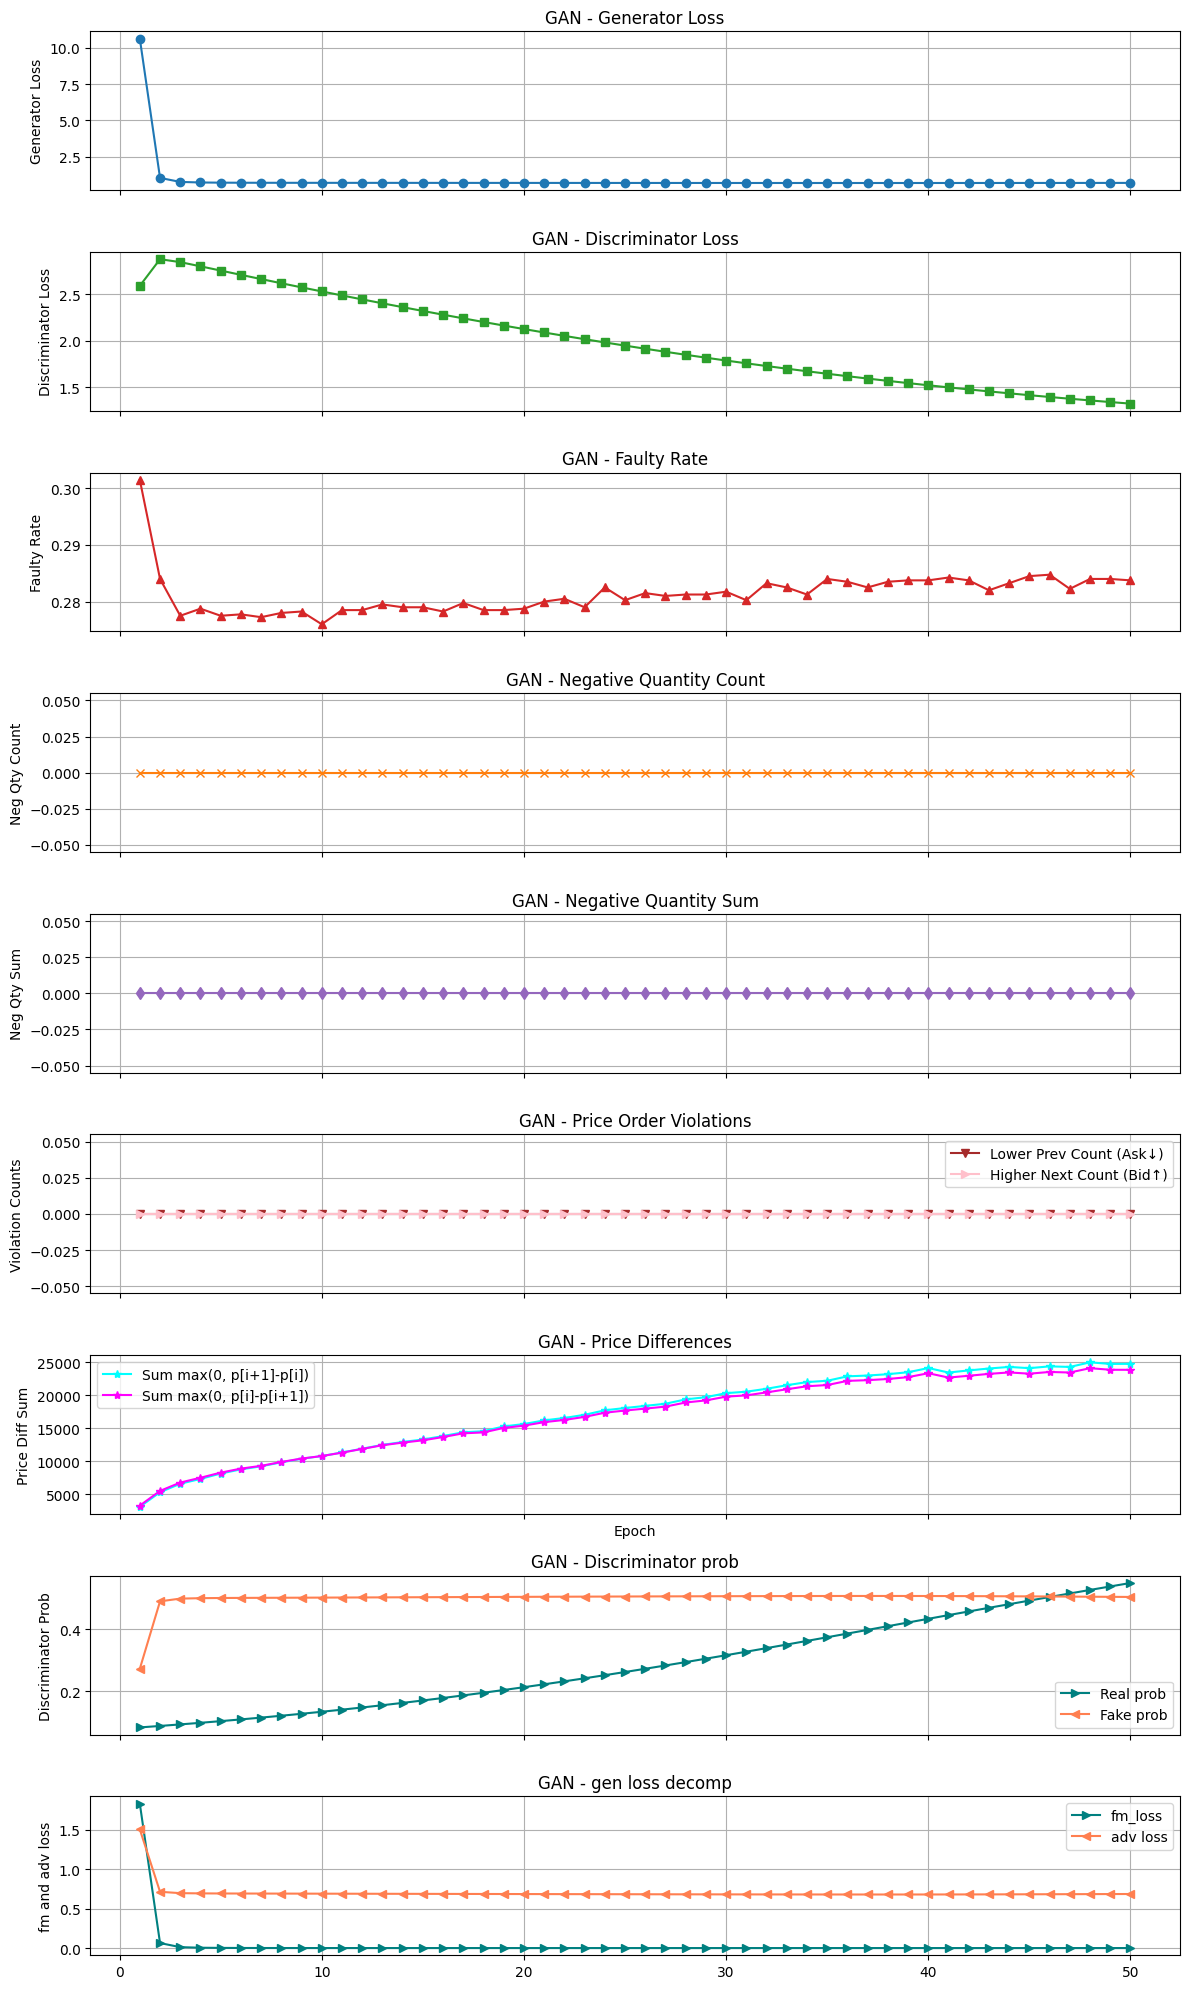

In [36]:
gan = SimpleGAN(config, use_minibatch_discrimination=False)

# History tracking
gen_loss_history = []
disc_loss_history = []
faulty_rate_history = []
real_prob_history = []
fake_prob_history = []
fm_loss_history = []
adv_loss_history = []

# Faulty stats tracking
neg_qty_count_history = []
neg_qty_sum_history = []
lower_prev_count_history = []
higher_next_count_history = []
diff_positive_sum_history = []
diff_negative_sum_history = []

for epoch in range(config.epochs):
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    epoch_real_prob = 0.0
    epoch_fake_prob = 0.0
    epoch_fm_loss = 0.0
    epoch_adv_loss = 0.0
    num_batches = 0

    for batch in lob_dataset:
        # Train discriminator once
        real_feature, disc_loss, real_prob, fake_prob = gan.train_step_once(batch)
        epoch_disc_loss += disc_loss
        epoch_real_prob += real_prob
        epoch_fake_prob += fake_prob

        times = 5
        # Train generator multiple times
        for _ in range(times):
            gen_loss, fm_loss, adv_loss = gan.train_generator_step(real_feature)
            epoch_gen_loss += gen_loss
            epoch_fm_loss += fm_loss
            epoch_adv_loss += adv_loss

        num_batches += 1

    avg_gen_loss = epoch_gen_loss / (num_batches * times)
    avg_disc_loss = epoch_disc_loss / num_batches
    avg_real_prob = epoch_real_prob / num_batches
    avg_fake_prob = epoch_fake_prob / num_batches
    avg_fm_loss = epoch_fm_loss / (num_batches *times)
    avg_adv_loss = epoch_adv_loss / (num_batches * times)

    gen_loss_history.append(float(avg_gen_loss))
    disc_loss_history.append(float(avg_disc_loss))
    real_prob_history.append(float(avg_real_prob))
    fake_prob_history.append(float(avg_fake_prob))
    fm_loss_history.append(float(avg_fm_loss))
    adv_loss_history.append(float(avg_adv_loss))

    # Generate LOB samples
    noise = tf.random.truncated_normal([100, config.z_dim])
    generated_samples = gan.generator(noise, training=False)

    # Faulty rate and stats
    faulty_rate = compute_faulty_rate(generated_samples)
    faulty_rate_scalar = float(np.mean(faulty_rate))
    faulty_rate_history.append(faulty_rate_scalar)

    stats = compute_faulty_stats(generated_samples)
    neg_qty_count_history.append(stats["neg_qty_count"])
    neg_qty_sum_history.append(stats["neg_qty_sum"])
    lower_prev_count_history.append(stats["lower_prev_count"])
    higher_next_count_history.append(stats["higher_next_count"])
    diff_positive_sum_history.append(stats["diff_positive_sum"])
    diff_negative_sum_history.append(stats["diff_negative_sum"])

    print(f"Epoch {epoch+1}/{config.epochs} - "
          f"Gen Loss: {avg_gen_loss:.4f}, "
          f"Disc Loss: {avg_disc_loss:.4f}, "
          f"Faulty Rate: {faulty_rate_scalar:.4f}")

# Plot everything
plot_training_trends(
    gen_loss_history,
    disc_loss_history,
    faulty_rate_history,
    neg_qty_count_history,
    neg_qty_sum_history,
    lower_prev_count_history,
    higher_next_count_history,
    diff_positive_sum_history,
    diff_negative_sum_history,
    real_prob_history,
    fake_prob_history,
    fm_loss_history,
    adv_loss_history,
    label_prefix="GAN"
)


### Testing Minibatch Discriminator

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['discriminator_3/dense_43/kernel', 'discriminator_3/dense_43/bias', 'discriminator_3/dense_44/kernel', 'discriminator_3/dense_44/bias', 'discriminator_3/dense_45/kernel', 'discriminator_3/dense_45/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1/50 - Gen Loss: 22.0319, Disc Loss: 10.7021, Faulty Rate: 0.3052
Epoch 2/50 - Gen Loss: 11.2228, Disc Loss: 8.9523, Faulty Rate: 0.3063
Epoch 3/50 - Gen Loss: 9.5317, Disc Loss: 7.2416, Faulty Rate: 0.3153
Epoch 4/50 - Gen Loss: 8.1073, Disc Loss: 5.8163, Faulty Rate: 0.3018
Epoch 5/50 - Gen Loss: 7.7699, Disc Loss: 4.4315, Faulty Rate: 0.3105
Epoch 6/50 - Gen Loss: 7.1776, Disc Loss: 3.1939, Faulty Rate: 0.3097
Epoch 7/50 - Gen Loss: 6.7318, Disc Loss: 2.1967, Faulty Rate: 0.3018
Epoch 8/50 - Gen Loss: 6.3241, Disc Loss: 1.4934, Faulty Rate: 0.2842
Epoch 9/50 - Gen Loss: 6.0642, Disc Loss: 1.0640, Faulty Rate: 0.2740
Epoch 10/50 - Gen Loss: 5.8710, Disc Loss: 0.8153, Faulty Rate: 0.2752
Epoch 11/50 - Gen Loss: 5.7454, Disc Loss: 0.6801, Faulty Rate: 0.2752
Epoch 12/50 - Gen Loss: 5.6430, Disc Loss: 0.6012, Faulty Rate: 0.2752
Epoch 13/50 - Gen Loss: 5.5489, Disc Loss: 0.5584, Faulty Rate: 0.2727
Epoch 14/50 - Gen Loss: 3.4585, Disc Loss: 1.9083, Faulty Rate: 0.2865
Epoch 15/50 

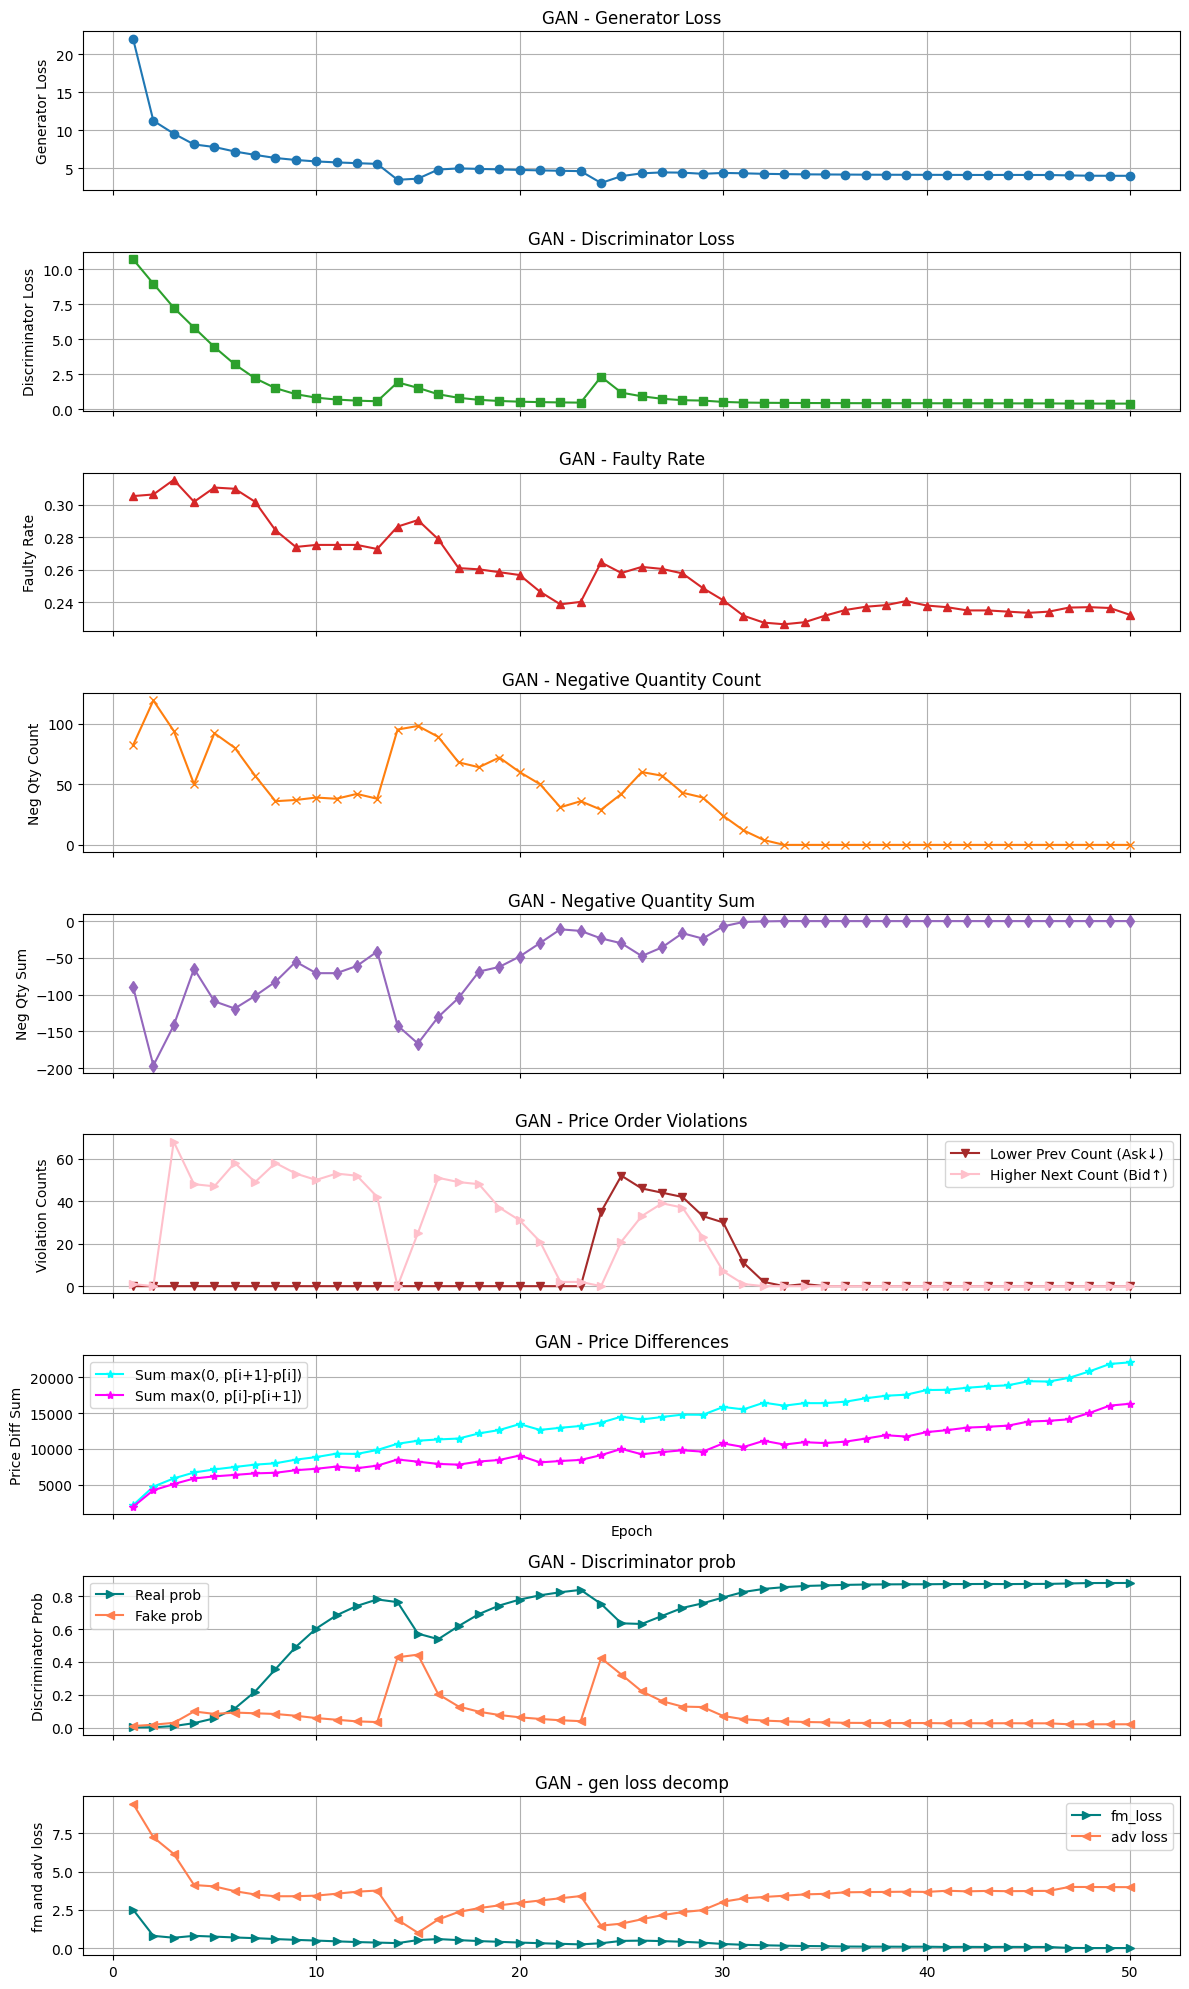

In [31]:
gan = SimpleGAN(config, use_minibatch_discrimination=True)

# History tracking
gen_loss_history = []
disc_loss_history = []
faulty_rate_history = []
real_prob_history = []
fake_prob_history = []
fm_loss_history = []
adv_loss_history = []

# Faulty stats tracking
neg_qty_count_history = []
neg_qty_sum_history = []
lower_prev_count_history = []
higher_next_count_history = []
diff_positive_sum_history = []
diff_negative_sum_history = []

for epoch in range(config.epochs):
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    epoch_real_prob = 0.0
    epoch_fake_prob = 0.0
    epoch_fm_loss = 0.0
    epoch_adv_loss = 0.0
    num_batches = 0

    for batch in lob_dataset:
        # Train discriminator once
        real_feature, disc_loss, real_prob, fake_prob = gan.train_step_once(batch)
        epoch_disc_loss += disc_loss
        epoch_real_prob += real_prob
        epoch_fake_prob += fake_prob

        times = 5
        # Train generator multiple times
        for _ in range(times):
            gen_loss, fm_loss, adv_loss = gan.train_generator_step(real_feature)
            epoch_gen_loss += gen_loss
            epoch_fm_loss += fm_loss
            epoch_adv_loss += adv_loss

        num_batches += 1

    avg_gen_loss = epoch_gen_loss / (num_batches * times)
    avg_disc_loss = epoch_disc_loss / num_batches
    avg_real_prob = epoch_real_prob / num_batches
    avg_fake_prob = epoch_fake_prob / num_batches
    avg_fm_loss = epoch_fm_loss / (num_batches *times)
    avg_adv_loss = epoch_adv_loss / (num_batches * times)

    gen_loss_history.append(float(avg_gen_loss))
    disc_loss_history.append(float(avg_disc_loss))
    real_prob_history.append(float(avg_real_prob))
    fake_prob_history.append(float(avg_fake_prob))
    fm_loss_history.append(float(avg_fm_loss))
    adv_loss_history.append(float(avg_adv_loss))

    # Generate LOB samples
    noise = tf.random.truncated_normal([100, config.z_dim])
    generated_samples = gan.generator(noise, training=False)

    # Faulty rate and stats
    faulty_rate = compute_faulty_rate(generated_samples)
    faulty_rate_scalar = float(np.mean(faulty_rate))
    faulty_rate_history.append(faulty_rate_scalar)

    stats = compute_faulty_stats(generated_samples)
    neg_qty_count_history.append(stats["neg_qty_count"])
    neg_qty_sum_history.append(stats["neg_qty_sum"])
    lower_prev_count_history.append(stats["lower_prev_count"])
    higher_next_count_history.append(stats["higher_next_count"])
    diff_positive_sum_history.append(stats["diff_positive_sum"])
    diff_negative_sum_history.append(stats["diff_negative_sum"])

    print(f"Epoch {epoch+1}/{config.epochs} - "
          f"Gen Loss: {avg_gen_loss:.4f}, "
          f"Disc Loss: {avg_disc_loss:.4f}, "
          f"Faulty Rate: {faulty_rate_scalar:.4f}")

# Plot everything
plot_training_trends(
    gen_loss_history,
    disc_loss_history,
    faulty_rate_history,
    neg_qty_count_history,
    neg_qty_sum_history,
    lower_prev_count_history,
    higher_next_count_history,
    diff_positive_sum_history,
    diff_negative_sum_history,
    real_prob_history,
    fake_prob_history,
    fm_loss_history,
    adv_loss_history,
    label_prefix="GAN"
)


HA & LS

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['discriminator_8/dense_103/kernel', 'discriminator_8/dense_103/bias', 'discriminator_8/dense_104/kernel', 'discriminator_8/dense_104/bias', 'discriminator_8/dense_105/kernel', 'discriminator_8/dense_105/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1/50 - Gen Loss: 7.7456, Disc Loss: 1.4279, Faulty Rate: 0.2490
Epoch 2/50 - Gen Loss: 0.8994, Disc Loss: 1.1661, Faulty Rate: 0.2498
Epoch 3/50 - Gen Loss: 0.7359, Disc Loss: 1.1509, Faulty Rate: 0.2500
Epoch 4/50 - Gen Loss: 0.7117, Disc Loss: 1.1395, Faulty Rate: 0.2500
Epoch 5/50 - Gen Loss: 0.7049, Disc Loss: 1.1289, Faulty Rate: 0.2500
Epoch 6/50 - Gen Loss: 0.7026, Disc Loss: 1.1189, Faulty Rate: 0.2500
Epoch 7/50 - Gen Loss: 0.7020, Disc Loss: 1.1096, Faulty Rate: 0.2500
Epoch 8/50 - Gen Loss: 0.7021, Disc Loss: 1.1009, Faulty Rate: 0.2500
Epoch 9/50 - Gen Loss: 0.7026, Disc Loss: 1.0927, Faulty Rate: 0.2500
Epoch 10/50 - Gen Loss: 0.7033, Disc Loss: 1.0850, Faulty Rate: 0.2500
Epoch 11/50 - Gen Loss: 0.7041, Disc Loss: 1.0777, Faulty Rate: 0.2500
Epoch 12/50 - Gen Loss: 0.7050, Disc Loss: 1.0709, Faulty Rate: 0.2500
Epoch 13/50 - Gen Loss: 0.7059, Disc Loss: 1.0645, Faulty Rate: 0.2500
Epoch 14/50 - Gen Loss: 0.7069, Disc Loss: 1.0584, Faulty Rate: 0.2500
Epoch 15/50 - G

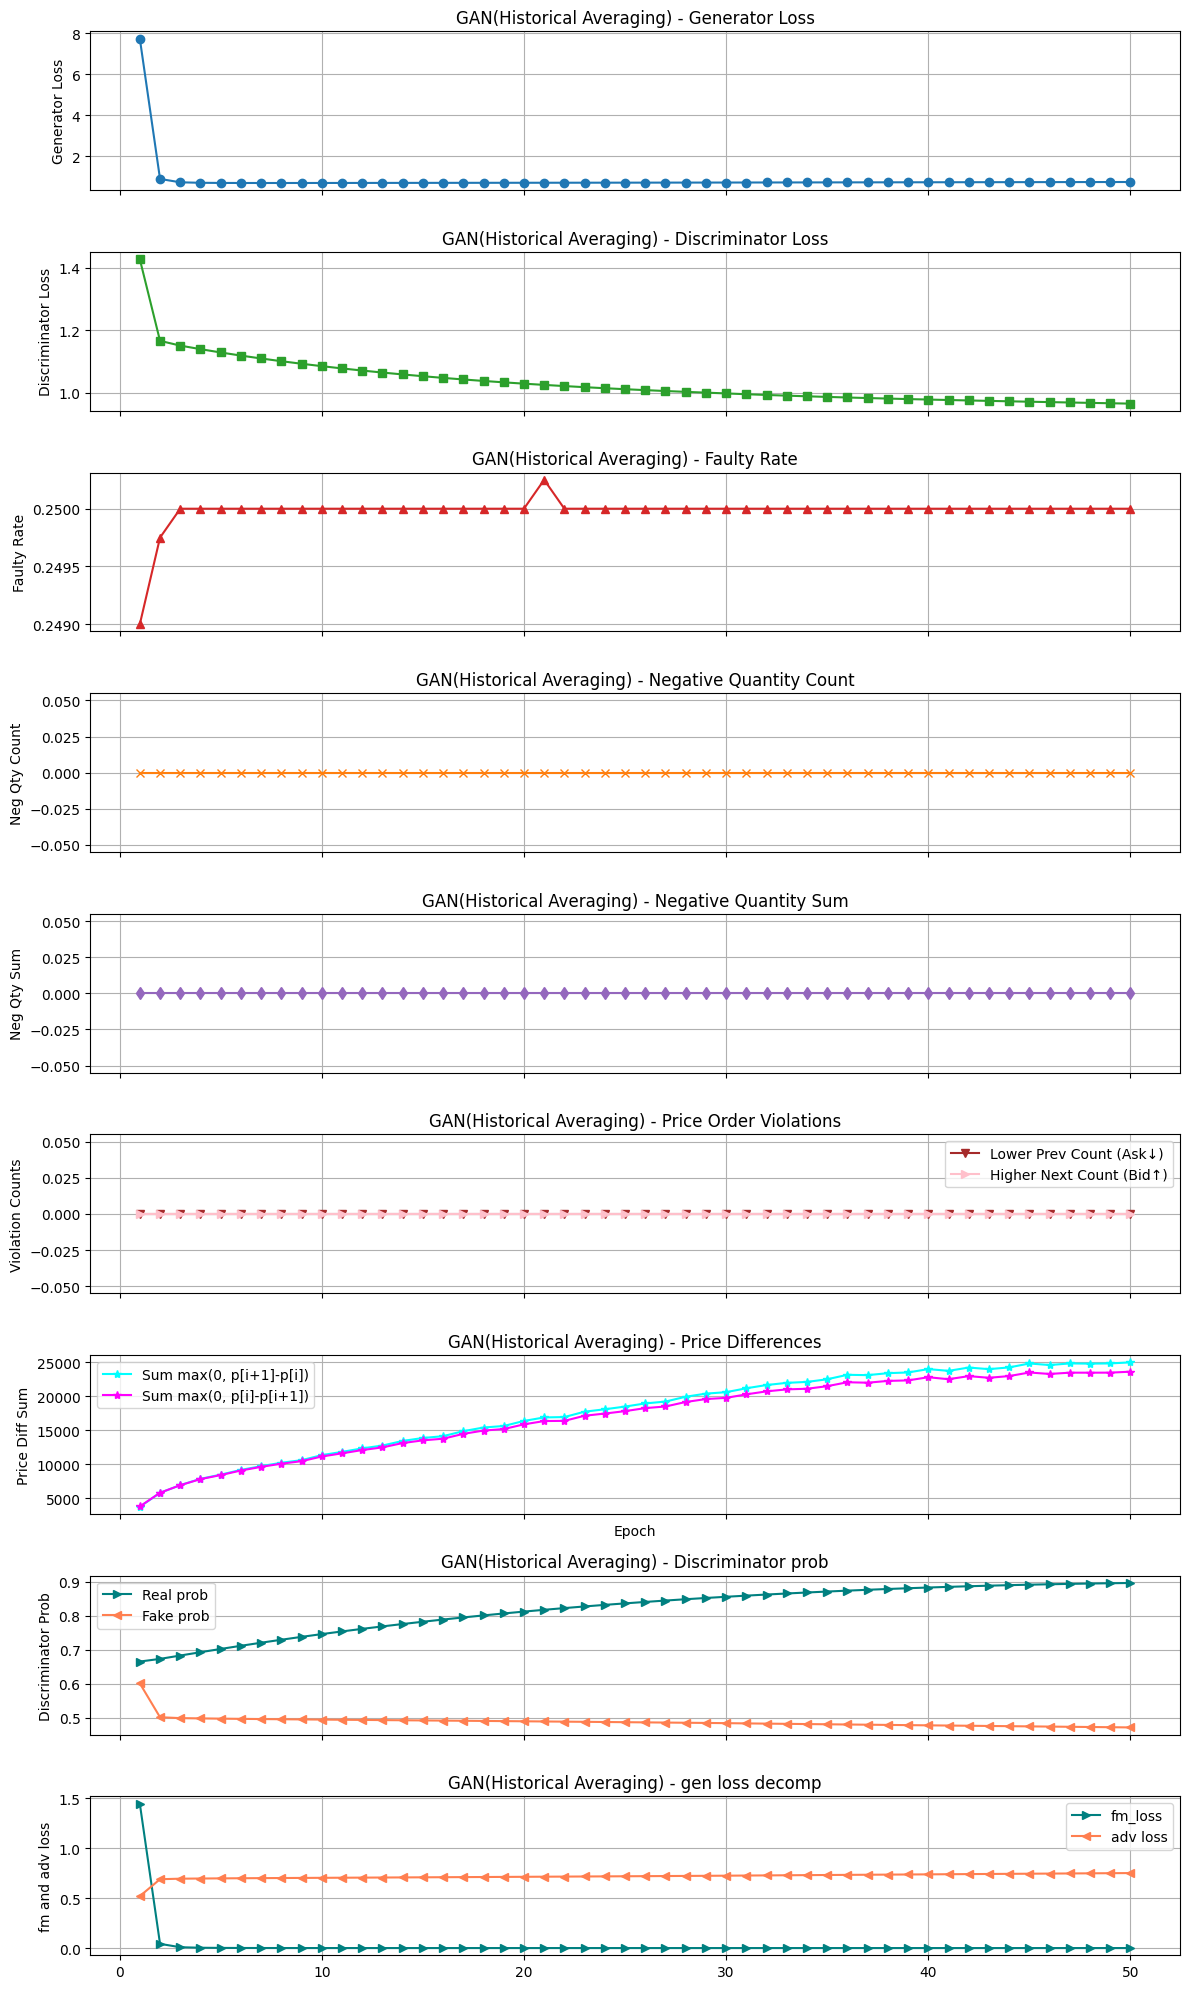

In [37]:
config_ha = Config(use_historical_averaging=True)

gan = SimpleGAN(config_ha, use_minibatch_discrimination=False)

# History tracking
gen_loss_history = []
disc_loss_history = []
faulty_rate_history = []
real_prob_history = []
fake_prob_history = []
fm_loss_history = []
adv_loss_history = []

# Faulty stats tracking
neg_qty_count_history = []
neg_qty_sum_history = []
lower_prev_count_history = []
higher_next_count_history = []
diff_positive_sum_history = []
diff_negative_sum_history = []

for epoch in range(config.epochs):
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    epoch_real_prob = 0.0
    epoch_fake_prob = 0.0
    epoch_fm_loss = 0.0
    epoch_adv_loss = 0.0
    num_batches = 0

    for batch in lob_dataset:
        # Train discriminator once
        real_feature, disc_loss, real_prob, fake_prob = gan.train_step_once(batch)
        epoch_disc_loss += disc_loss
        epoch_real_prob += real_prob
        epoch_fake_prob += fake_prob

        times = 5
        # Train generator multiple times
        for _ in range(times):
            gen_loss, fm_loss, adv_loss = gan.train_generator_step(real_feature)
            epoch_gen_loss += gen_loss
            epoch_fm_loss += fm_loss
            epoch_adv_loss += adv_loss

        num_batches += 1

    avg_gen_loss = epoch_gen_loss / (num_batches * times)
    avg_disc_loss = epoch_disc_loss / num_batches
    avg_real_prob = epoch_real_prob / num_batches
    avg_fake_prob = epoch_fake_prob / num_batches
    avg_fm_loss = epoch_fm_loss / (num_batches *times)
    avg_adv_loss = epoch_adv_loss / (num_batches * times)

    gen_loss_history.append(float(avg_gen_loss))
    disc_loss_history.append(float(avg_disc_loss))
    real_prob_history.append(float(avg_real_prob))
    fake_prob_history.append(float(avg_fake_prob))
    fm_loss_history.append(float(avg_fm_loss))
    adv_loss_history.append(float(avg_adv_loss))

    # Generate LOB samples
    noise = tf.random.truncated_normal([100, config.z_dim])
    generated_samples = gan.generator(noise, training=False)

    # Faulty rate and stats
    faulty_rate = compute_faulty_rate(generated_samples)
    faulty_rate_scalar = float(np.mean(faulty_rate))
    faulty_rate_history.append(faulty_rate_scalar)

    stats = compute_faulty_stats(generated_samples)
    neg_qty_count_history.append(stats["neg_qty_count"])
    neg_qty_sum_history.append(stats["neg_qty_sum"])
    lower_prev_count_history.append(stats["lower_prev_count"])
    higher_next_count_history.append(stats["higher_next_count"])
    diff_positive_sum_history.append(stats["diff_positive_sum"])
    diff_negative_sum_history.append(stats["diff_negative_sum"])

    print(f"Epoch {epoch+1}/{config.epochs} - "
          f"Gen Loss: {avg_gen_loss:.4f}, "
          f"Disc Loss: {avg_disc_loss:.4f}, "
          f"Faulty Rate: {faulty_rate_scalar:.4f}")

# Plot everything
plot_training_trends(
    gen_loss_history,
    disc_loss_history,
    faulty_rate_history,
    neg_qty_count_history,
    neg_qty_sum_history,
    lower_prev_count_history,
    higher_next_count_history,
    diff_positive_sum_history,
    diff_negative_sum_history,
    real_prob_history,
    fake_prob_history,
    fm_loss_history,
    adv_loss_history,
    label_prefix="GAN(Historical Averaging)"
)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['discriminator_9/dense_115/kernel', 'discriminator_9/dense_115/bias', 'discriminator_9/dense_116/kernel', 'discriminator_9/dense_116/bias', 'discriminator_9/dense_117/kernel', 'discriminator_9/dense_117/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1/50 - Gen Loss: 8.7612, Disc Loss: 2.4923, Faulty Rate: 0.3005
Epoch 2/50 - Gen Loss: 0.9312, Disc Loss: 2.6246, Faulty Rate: 0.3000
Epoch 3/50 - Gen Loss: 0.7376, Disc Loss: 2.5823, Faulty Rate: 0.3000
Epoch 4/50 - Gen Loss: 0.7085, Disc Loss: 2.5382, Faulty Rate: 0.3000
Epoch 5/50 - Gen Loss: 0.6989, Disc Loss: 2.4947, Faulty Rate: 0.3000
Epoch 6/50 - Gen Loss: 0.6947, Disc Loss: 2.4517, Faulty Rate: 0.3000
Epoch 7/50 - Gen Loss: 0.6924, Disc Loss: 2.4094, Faulty Rate: 0.3000
Epoch 8/50 - Gen Loss: 0.6909, Disc Loss: 2.3680, Faulty Rate: 0.3000
Epoch 9/50 - Gen Loss: 0.6899, Disc Loss: 2.3272, Faulty Rate: 0.3000
Epoch 10/50 - Gen Loss: 0.6891, Disc Loss: 2.2872, Faulty Rate: 0.3000
Epoch 11/50 - Gen Loss: 0.6884, Disc Loss: 2.2478, Faulty Rate: 0.3000
Epoch 12/50 - Gen Loss: 0.6878, Disc Loss: 2.2092, Faulty Rate: 0.3000
Epoch 13/50 - Gen Loss: 0.6872, Disc Loss: 2.1713, Faulty Rate: 0.3000
Epoch 14/50 - Gen Loss: 0.6867, Disc Loss: 2.1341, Faulty Rate: 0.3000
Epoch 15/50 - G

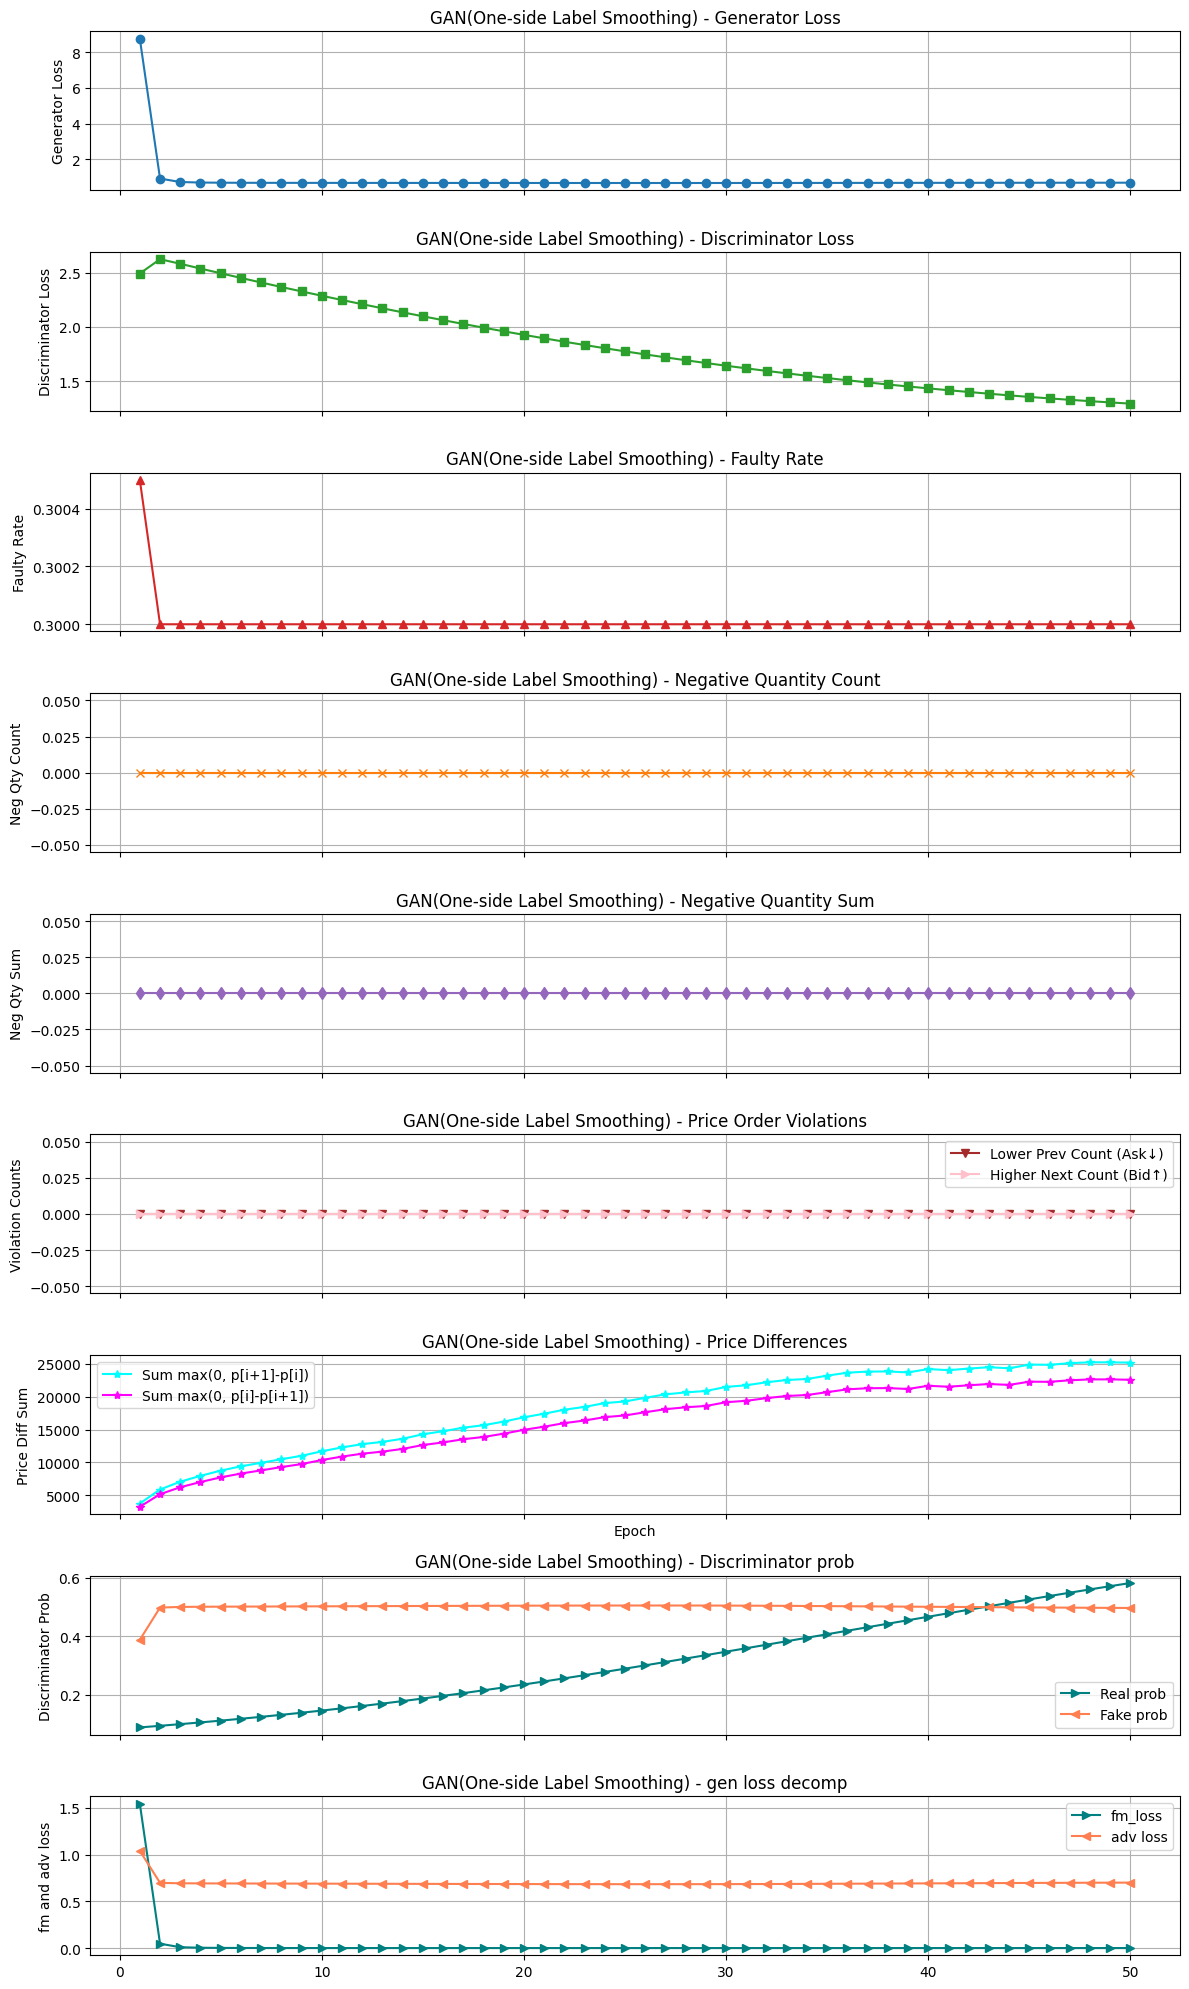

In [38]:
config_ls = Config(label_smoothing=0.1)

gan = SimpleGAN(config_ls, use_minibatch_discrimination=False)

# History tracking
gen_loss_history = []
disc_loss_history = []
faulty_rate_history = []
real_prob_history = []
fake_prob_history = []
fm_loss_history = []
adv_loss_history = []

# Faulty stats tracking
neg_qty_count_history = []
neg_qty_sum_history = []
lower_prev_count_history = []
higher_next_count_history = []
diff_positive_sum_history = []
diff_negative_sum_history = []

for epoch in range(config.epochs):
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    epoch_real_prob = 0.0
    epoch_fake_prob = 0.0
    epoch_fm_loss = 0.0
    epoch_adv_loss = 0.0
    num_batches = 0

    for batch in lob_dataset:
        # Train discriminator once
        real_feature, disc_loss, real_prob, fake_prob = gan.train_step_once(batch)
        epoch_disc_loss += disc_loss
        epoch_real_prob += real_prob
        epoch_fake_prob += fake_prob

        times = 5
        # Train generator multiple times
        for _ in range(times):
            gen_loss, fm_loss, adv_loss = gan.train_generator_step(real_feature)
            epoch_gen_loss += gen_loss
            epoch_fm_loss += fm_loss
            epoch_adv_loss += adv_loss

        num_batches += 1

    avg_gen_loss = epoch_gen_loss / (num_batches * times)
    avg_disc_loss = epoch_disc_loss / num_batches
    avg_real_prob = epoch_real_prob / num_batches
    avg_fake_prob = epoch_fake_prob / num_batches
    avg_fm_loss = epoch_fm_loss / (num_batches *times)
    avg_adv_loss = epoch_adv_loss / (num_batches * times)

    gen_loss_history.append(float(avg_gen_loss))
    disc_loss_history.append(float(avg_disc_loss))
    real_prob_history.append(float(avg_real_prob))
    fake_prob_history.append(float(avg_fake_prob))
    fm_loss_history.append(float(avg_fm_loss))
    adv_loss_history.append(float(avg_adv_loss))

    # Generate LOB samples
    noise = tf.random.truncated_normal([100, config.z_dim])
    generated_samples = gan.generator(noise, training=False)

    # Faulty rate and stats
    faulty_rate = compute_faulty_rate(generated_samples)
    faulty_rate_scalar = float(np.mean(faulty_rate))
    faulty_rate_history.append(faulty_rate_scalar)

    stats = compute_faulty_stats(generated_samples)
    neg_qty_count_history.append(stats["neg_qty_count"])
    neg_qty_sum_history.append(stats["neg_qty_sum"])
    lower_prev_count_history.append(stats["lower_prev_count"])
    higher_next_count_history.append(stats["higher_next_count"])
    diff_positive_sum_history.append(stats["diff_positive_sum"])
    diff_negative_sum_history.append(stats["diff_negative_sum"])

    print(f"Epoch {epoch+1}/{config.epochs} - "
          f"Gen Loss: {avg_gen_loss:.4f}, "
          f"Disc Loss: {avg_disc_loss:.4f}, "
          f"Faulty Rate: {faulty_rate_scalar:.4f}")

# Plot everything
plot_training_trends(
    gen_loss_history,
    disc_loss_history,
    faulty_rate_history,
    neg_qty_count_history,
    neg_qty_sum_history,
    lower_prev_count_history,
    higher_next_count_history,
    diff_positive_sum_history,
    diff_negative_sum_history,
    real_prob_history,
    fake_prob_history,
    fm_loss_history,
    adv_loss_history,
    label_prefix="GAN(One-side Label Smoothing)"
)